# Autoencoders Variacionais (VAE)

Nome: Harrison Caetano Candido
RA: 156264

Modelos generativos são aqueles que geram novos dados a partir de um conhecimento inicial. Esses modelos aprendem estruturas de dados subjacentes e usa o aprendizado para gerar estruturas semelhantes.

- P(X,Y): Um modelo generativo se baseia na probabilidade de X e Y acontecerem, como em **P(verão, dia ensoralado)** ou seja, algo como a probabilidade de ser verão e o dia estar ensolarado.

Podemos utilizar a abordagem de redes neurais generativas ou modelos autoregressivos.

## Autoencoders
Na forma padrão os Autoencoders são redes neurais multilayerperceptron fully-connected, com camadas densas convolucionais para extração de informação de imagens ou recorrentes para series temporais. Um autoencoder pode é composto por um codificador e um decodificador.

Um codificador é capaz de gerar dados não estruturados, enquanto um decodificador é capaz de entender novas informações não estruturadas.

- **Espaço Latente:** É o espaço de todas as possíveis representações latentes. Os Autoencoders aprendem o espaço latente, que captura as características importantes dos dados.
  - Note que regiões do espaço latente que não forem aprendidas gerarão dados incorretos ou inadequados para alguma finalidade.
  - Busca-se assim um espaço latente contínuo e navegável quando falamos de Autoencoder Variacional.

- **Compressão da entrada:** Um Codificador transforma a entrada em uma representação latente, de dimensão menor do que os dados originais.
- **Reconstrução da entrada:** Um decodificador pega uma representação latente e tenta reconstruir a entrada original.

Objetivo: São treinados para minimizar a diferença da representação de entrada com a de saída.

- **Autoencoder Vanilla (Padrão):** É determinístico. Faz o mapeamento de uma entrada ser sempre a mesma saída, pois mapeia um único ponto no espaço latente. Por conta disso o espaço latente pode ser descontínuo e irregular, o que não atende ao Autoencoder Variacional.

- **Autoencoder Variacional:** Faz um mapeamento não determínistico para pontos no espaço latente. O VAE mapeia cada entrada para uma distribuição de probabilidade sobre o espaço latente.

  Função de Custo (F. de Perda):
  - Erro de reconstrução: visa minimizar a diferença entre a entrada e a saída, assim como no Vanilla.
  - Regularização: Usa a divergência KL para penalizar o modelo. A penalização incide sobre a diferença entre uma distribuição latente aprendida e uma distribuição a priori (geralmente uma distribuição padrão).

O Autoencoder Padrão é útil geralmente apenas paara a reconstrução. Já o Variacional é útil para reconstrução e regularização do espaço latente.

**Objetivo:** Selecionar dois datasets rotulados e treinar modelos VAEs. Será necessário ajustar o melhor modelo cometer peeking. para isso utilizaremos validação cruzada no treinamento.

**Espaço Latente:** Será necessário gerar gráficos com a projeção do espaço latente em 2D (PCA), com rótulos nas características.

Responder às questões:
- Há formação de clusters no espaço latente?
- Há separação dos rótulos no espaço latente?
- A projeção ilustra quanto da variância?


In [ ]:
!pip install torchinfo

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchinfo import summary
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  # Import PCA


import numpy as np, matplotlib.pyplot as plt

#dataset MNIST do scikit-learn
from sklearn.datasets import fetch_openml

In [ ]:
print(f"Pytorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name()}")
else:
    print("No CUDA-enabled GPU found. Using CPU instead.")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f'Total number of GPUs: {torch.cuda.device_count()}')

Pytorch Version: 2.5.1+cu124
Torchvision Version: 0.20.1+cu124
No CUDA-enabled GPU found. Using CPU instead.
Device: cpu
Total number of GPUs: 0


Cada imagem possui 8 bits, o que nos da 256 possibilidades de tons de cinza. Essa normalização, obtida dividindo os valores originais por 255, otimiza o desempenho da rede neural. Facilita o aprendizado, evita problemas de gradiente e é compatível com funções de ativação comuns como a Sigmoid.

In [ ]:
# carrego o dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# visualizo as 70.000 imagens, cada uma com 784 pixels
X, y = mnist["data"], mnist["target"]

print(X.shape)
print(y.shape)

mnist_dataset = X
mnist_labels = y
print('maior valor de imagem: ', mnist_dataset.max(),'\nmenor valor de imagem:', mnist_dataset.min())

(70000, 784)
(70000,)
maior valor de imagem:  255 
menor valor de imagem: 0


In [ ]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)

# Normalizo os dados para o intervalo [0, 1] a fim de que
# a funcao de ativacao seja corretamente aplicada
X = X / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% treinamento, 20% teste
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% treinamento, 20% validação, 20% teste

X_train = torch.from_numpy(X_train).view(-1, 1, 28, 28)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val).view(-1, 1, 28, 28)
X_test = torch.from_numpy(X_test).view(-1, 1, 28, 28)
y_test = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TypeError: 'int' object is not callable

In [ ]:
class AutoencoderVanilla(nn.Module):
  def __init__(self):
    super().__init__()
    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 28, 28)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 14, 14)
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (N, 64, 14, 14)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 64, 7, 7)
      )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (N, 32, 14, 14)
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # (N, 1, 28, 28)
        nn.Sigmoid()
      )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
model = AutoencoderVanilla()
criterion = nn.MSELoss()
# otimizamos os parametros do modelo com ADAM
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Epoch:1, Train Loss:0.0000, Val Loss:0.0000


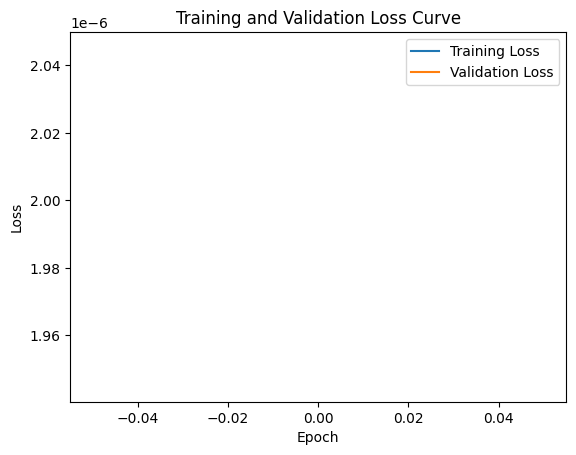

In [ ]:
num_epochs = 1

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Modo de treinamento
    model.train()
    train_loss = 0.0
    for (img, _) in train_loader:
        # Forward pass
        recon_batch = model(img)
        loss = criterion(recon_batch, img)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Modo de avaliação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (img, _) in val_loader:
            # Forward pass
            recon_batch = model(img)
            loss = criterion(recon_batch, img)

            val_loss += loss.item()

    # Calcular a perda média
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Imprimir a perda
    print(f'Epoch:{epoch+1}, Train Loss:{train_loss:.4f}, Val Loss:{val_loss:.4f}')

    # Armazenar a perda
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotar a curva de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
class VariationalConvolutionalAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VariationalConvolutionalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (N, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 64, 7, 7)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (N, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 128, 3, 3)
        )

        self.linear_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.linear_logvar = nn.Linear(128 * 3 * 3, latent_dim)

        # Decoder
        self.decoder_lin1 = nn.Linear(latent_dim, 128 * 3 * 3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # (N, 64, 6, 6)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (N, 32, 12, 12)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # (N, 1, 24, 24)
            nn.Sigmoid()
        )

        self.conv_out = nn.Conv2d(1,1, kernel_size=3, padding=2)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 3 * 3)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_lin1(z)
        z = z.view(-1, 128, 3, 3) # Reshape z

        x_hat = self.decoder(z)
        x_hat = F.interpolate(x_hat, size=(28,28), mode='bilinear', align_corners=False) #Interpolação bilinear        x_hat = self.conv_out(x_hat)

        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32
model = VariationalConvolutionalAutoencoder(latent_dim).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1):
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return bce_loss + beta * kl_divergence

Epoch:1, Train Loss:45.9959, Val Loss:2.3444
Epoch:2, Train Loss:1.1548, Val Loss:0.5610
Epoch:3, Train Loss:0.3617, Val Loss:0.2310
Epoch:4, Train Loss:0.1667, Val Loss:0.1196
Epoch:5, Train Loss:0.0926, Val Loss:0.0715
Epoch:6, Train Loss:0.0585, Val Loss:0.0480
Epoch:7, Train Loss:0.0412, Val Loss:0.0357
Epoch:8, Train Loss:0.0320, Val Loss:0.0290
Epoch:9, Train Loss:0.0270, Val Loss:0.0254
Epoch:10, Train Loss:0.0243, Val Loss:0.0233
Epoch:11, Train Loss:0.0228, Val Loss:0.0224
Epoch:12, Train Loss:0.0220, Val Loss:0.0220
Epoch:13, Train Loss:0.0215, Val Loss:0.0231
Epoch:14, Train Loss:0.0213, Val Loss:0.0220
Epoch:15, Train Loss:0.0212, Val Loss:0.0215
Epoch:16, Train Loss:0.0211, Val Loss:0.0210
Epoch:17, Train Loss:0.0211, Val Loss:0.0209
Epoch:18, Train Loss:0.0210, Val Loss:0.0209
Epoch:19, Train Loss:0.0210, Val Loss:0.0209
Epoch:20, Train Loss:0.0210, Val Loss:0.0209


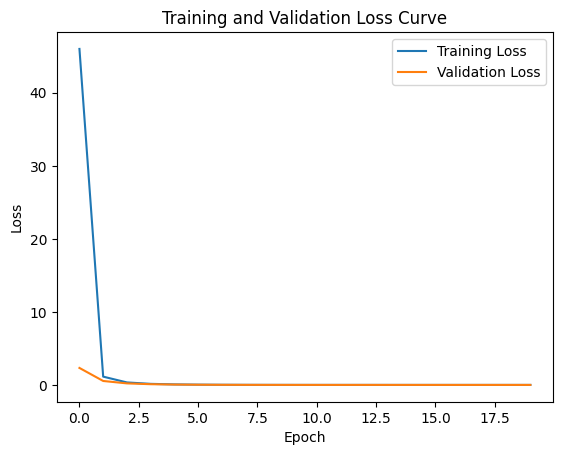

In [ ]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for (img, _) in train_loader:
        img = img.to(device) #Movo para o device
        # Forward pass
        recon_batch, mu, logvar = model(img)
        loss = vae_loss(recon_batch, img, mu, logvar)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Modo de avaliação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (img, _) in val_loader:
            # Aplano as imagens
            img = img.to(device)

            # Forward pass
            recon_batch, mu, logvar = model(img)
            loss = vae_loss(recon_batch, img, mu, logvar)

            val_loss += loss.item()

    # Calculo a perda média
    train_loss /= len(train_loader.dataset)  # Normalizo pelo tamanho do conjunto de dados
    val_loss /= len(val_loader.dataset)  # Normalizo pelo tamanho do conjunto de dados

    print(f'Epoch:{epoch+1}, Train Loss:{train_loss:.4f}, Val Loss:{val_loss:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

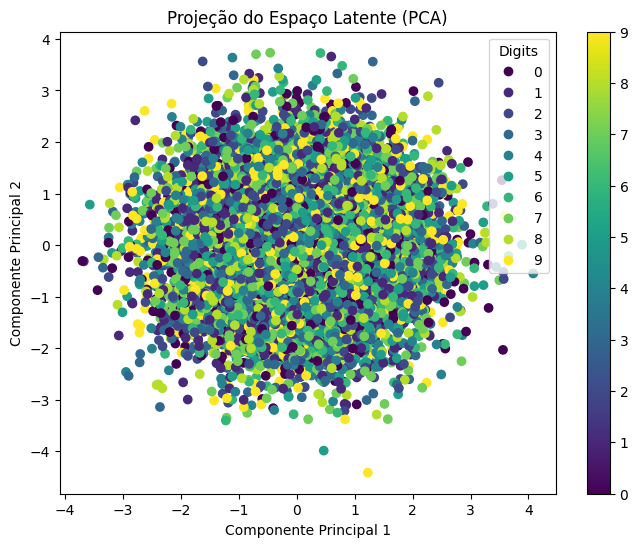

In [ ]:
model.eval()
latent_representations = []
val_labels = []
with torch.no_grad():
    for img, label in val_loader:
        img = img.to(device)
        mu, logvar = model.encode(img)
        z = model.reparameterize(mu, logvar)
        latent_representations.extend(z.cpu().numpy())  # Movo para a CPU e converter para NumPy
        val_labels.extend(label.numpy())

latent_representations = np.array(latent_representations)
val_labels = np.array(val_labels)

# Aplico PCA para reduzir a dimensionalidade para 2D
pca = PCA(n_components=2)
latent_representations_2d = pca.fit_transform(latent_representations)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=val_labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Projeção do Espaço Latente (PCA)")
plt.colorbar()
plt.show()

In [ ]:
model.eval()  # Modo de avaliação
test_loss = 0.0
with torch.no_grad():
    for img, _ in test_loader:
        # Forward pass
        recon_batch = model(img)
        loss = criterion(recon_batch, img)

        test_loss += loss.item()

# Calcular a perda média no conjunto de teste
test_loss /= len(test_loader)

# Imprimir a perda no conjunto de teste
print(f'Test Loss:{test_loss:.4f}')

# Plotar a curva de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Segundo Dataset
 Fashion-MNIST, um substituto mais desafiador para o MNIST, contendo imagens de roupas e acessórios (10 classes).

**OBS:** Mesma perda e otimizador para o dataset Digits MNIST

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),  #Converte as imagens para tensores
])

# Carregar o dataset FashionMNIST
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Tamanhos dos datasets
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

cpu


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.02MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [ ]:
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class VariationalConvolutionalAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(VariationalConvolutionalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (N, 32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 32, 7, 7)
        )

        self.linear_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.linear_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_lin1 = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1), #Ajustada para 28x28
            nn.Sigmoid()  #Output entre 0 e 1
        )

        # Upsample
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 32 * 7 * 7)
        mu = self.linear_mu(x)
        logvar = self.linear_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_lin1(z)
        z = z.view(-1, 32, 7, 7) # Reshape z
        x_hat = self.decoder(z)
        x_hat = self.upsample(x_hat)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

latent_dim = 32
model = VariationalConvolutionalAutoencoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1):
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') #Calcular a média da BCE
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_divergence = torch.mean(kl_divergence)
    return (bce_loss + beta * kl_divergence)


In [ ]:

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = vae_loss(recon_batch, img, mu, logvar, beta=0.1) #Adjust the beta
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, _ in test_loader:
            img = img.to(device)
            recon_batch, mu, logvar = model(img)
            loss = vae_loss(recon_batch, img, mu, logvar, beta=0.1)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)

    print(f'Epoch:{epoch+1}, Train Loss:{train_loss:.4f}, Val Loss:{val_loss:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)



Epoch:1, Train Loss:0.5249, Val Loss:0.4977
Epoch:2, Train Loss:0.4952, Val Loss:0.4949
Epoch:3, Train Loss:0.4938, Val Loss:0.4938
Epoch:4, Train Loss:0.4932, Val Loss:0.4939
Epoch:5, Train Loss:0.4931, Val Loss:0.4935


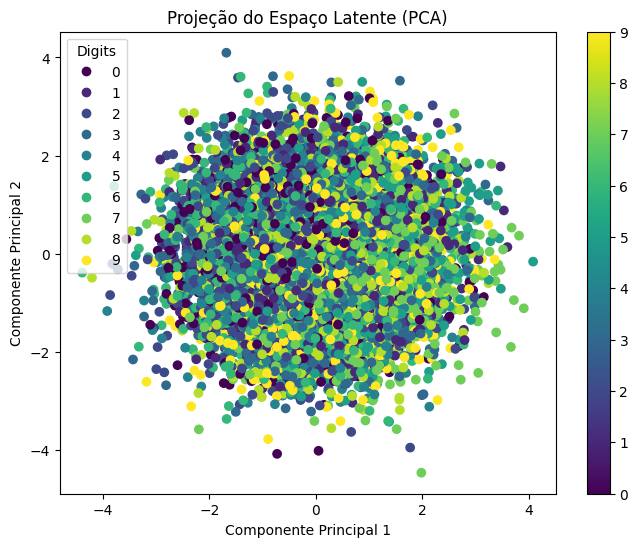

In [ ]:
model.eval()
latent_representations = []
val_labels = []
with torch.no_grad():
    for img, label in val_loader:
        img = img.to(device)
        mu, logvar = model.encode(img)
        z = model.reparameterize(mu, logvar)
        latent_representations.extend(z.cpu().numpy())  # Movo para a CPU e converter para NumPy
        val_labels.extend(label.numpy())

latent_representations = np.array(latent_representations)
val_labels = np.array(val_labels)

# Aplico PCA para reduzir a dimensionalidade para 2D
pca = PCA(n_components=2)
latent_representations_2d = pca.fit_transform(latent_representations)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=val_labels, cmap='viridis')
plt.legend(*scatter.legend_elements(), title="Digits")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Projeção do Espaço Latente (PCA)")
plt.colorbar()
plt.show()

# Respostas comuns a ambos os datasets MNIST e FASHION MNIST
- **Há formação de clusters no espaço latente?**
 R: Na visualização fornecida, os pontos parecem estar espalhados de forma relativamente uniforme por todo o gráfico, sem a formação de clusters distintos e bem definidos. Há uma grande sobreposição entre as diferentes classes (cores), o que indica que o modelo não está conseguindo aprender representações latentes que separam bem as diferentes classes de dígitos.

- **Há separação dos rótulos no espaço latente?** R: As cores (que representam os rótulos dos dígitos) estão misturadas por todo o gráfico. Isso indica que o modelo não está aprendendo a mapear dígitos semelhantes para regiões próximas no espaço latente.

- **A projeção ilustra quanto da variância?** R: A projeção em 2D pode não ser suficiente para capturar a complexidade da estrutura do espaço latente original.